In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

In [2]:
# Helper functions to draw and visualize graph solution

import matplotlib.pyplot as plt
import networkx as nx

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos, node_shape="o")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

distance
 [[  0. 102.  19.  24.]
 [102.   0.  84.  93.]
 [ 19.  84.   0.  17.]
 [ 24.  93.  17.   0.]]


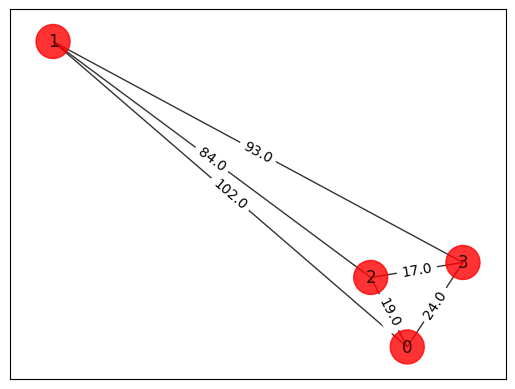

In [3]:
from qiskit_optimization.applications import Tsp

tsp = Tsp.create_random_instance(4, seed=43)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r"] * len(tsp.graph.nodes)
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

Converting the quadratic program to QUBO and Ising Hamiltonian
To solve this problem, we need to convert our quadratic program into a form that a quantum computer can work with. In this case we will generate an Ising Hamiltonian, which is simply a representation (i.e. model) of the energy of this particular system (i.e. problem). We can use eigensolvers to find the minimum energy of the Ising hamiltonian, which corresponds to the shortest path and the solution of our problem.

How do we get the Ising Hamiltonian? First, we convert the quadratic program to a QUBO (Quadratic Unconstrained Binary Optimization), a combinatorial optimization problem representation to then obtain an Ising Hamiltonian. The next code cell will teach you how we do this.

In [4]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp = tsp.to_quadratic_program()
qp2qubo = QuadraticProgramToQubo()  # instatiate qp to qubo class
qubo = qp2qubo.convert(qp)  # convert quadratic program to qubo
qubitOp, offset = qubo.to_ising()  # convert qubo to ising

print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 44086.0
Ising Hamiltonian:
-5498.5 * IIIIIIIIIIIIIIIZ
- 5498.5 * IIIIIIIIIIIIIIZI
- 5498.5 * IIIIIIIIIIIIIZII
- 5498.5 * IIIIIIIIIIIIZIII
- 5565.5 * IIIIIIIIIIIZIIII
- 5565.5 * IIIIIIIIIIZIIIII
- 5565.5 * IIIIIIIIIZIIIIII
- 5565.5 * IIIIIIIIZIIIIIII
- 5486.0 * IIIIIIIZIIIIIIII
- 5486.0 * IIIIIIZIIIIIIIII
- 5486.0 * IIIIIZIIIIIIIIII
- 5486.0 * IIIIZIIIIIIIIIII
- 5493.0 * IIIZIIIIIIIIIIII
- 5493.0 * IIZIIIIIIIIIIIII
- 5493.0 * IZIIIIIIIIIIIIII
- 5493.0 * ZIIIIIIIIIIIIIII
+ 1356.5 * IIIIIIIIIIIIIIZZ
+ 1356.5 * IIIIIIIIIIIIIZIZ
+ 1356.5 * IIIIIIIIIIIIIZZI
+ 1356.5 * IIIIIIIIIIIIZIIZ
+ 1356.5 * IIIIIIIIIIIIZIZI
+ 1356.5 * IIIIIIIIIIIIZZII
+ 1356.5 * IIIIIIIIIIIZIIIZ
+ 25.5 * IIIIIIIIIIIZIIZI
+ 25.5 * IIIIIIIIIIIZZIII
+ 25.5 * IIIIIIIIIIZIIIIZ
+ 1356.5 * IIIIIIIIIIZIIIZI
+ 25.5 * IIIIIIIIIIZIIZII
+ 1356.5 * IIIIIIIIIIZZIIII
+ 25.5 * IIIIIIIIIZIIIIZI
+ 1356.5 * IIIIIIIIIZIIIZII
+ 25.5 * IIIIIIIIIZIIZIII
+ 1356.5 * IIIIIIIIIZIZIIII
+ 1356.5 * IIIIIIIIIZZIIIII
+ 25.5 * IIIIIIIIZIIIIIIZ


Now it's time for you to construct a VQE using the SamplingVQE in Qiskit! SamplingVQE is one of the two versions of VQE that Qiskit offers today and uses the sampler primitive optimized for diagonal Hamiltonians. The optimizer and ansatz are already given to you.

Please complete the code block below to construct your VQE using SamplingVQE.

energy: -43033.65311434935
time: 2214.341359615326
feasible: True
solution: [1, 2, 3, 0]
solution objective: 227.0


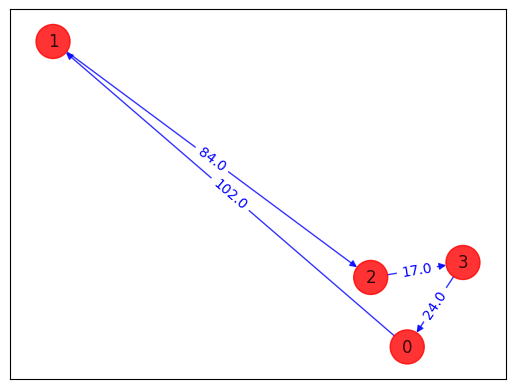

In [5]:
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import NFT
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 123

optimizer = NFT(maxiter=100)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=2, entanglement="linear")


vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [6]:
from qc_grader.challenges.quantum_explorers23 import grade_badge6_code

grade_badge6_code(tsp, qubo, result) # Expected result type: tsp: Tsp, qubo: QuadraticProgram, result: SamplingVQEResult

Submitting your answer. Please wait...
Congratulations! 🎉 Your answer is correct.
